In [1]:
!python -m pip install --upgrade pip
!python -m pip install keras-tuner

     |████████████████████████████████| 1.5 MB 4.7 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.1
    Uninstalling pip-20.1:
      Successfully uninstalled pip-20.1
     |████████████████████████████████| 54 kB 1.5 MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-py3-none-any.whl size=73198 sha256=5eb07528b7775d685647f28ae2bb42cf18a1c669ce8c33b66f8e3b899158de71
  Stored in directory: /root/.cache/pip/wheels/0b/cf/2f/1a1749d3a3650fac3305a8d7f9237b6de7c41068e2f8520ca2
  Created wheel for terminaltables: filename=terminaltables-3.1.0-py3-none-any.whl size=15354 sha256=04305838ccf65e8bed9af0076aba6fd7bf360bd06ee619c0e8e3921ba041008b
  Stored in directory: /root/.cache/pip/wheels/ba/ad/c8/2d98360791161cd3db6daf6b5e730f34021fc9367d5879f497
Successfully built keras-tuner terminaltables


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline
# notebook

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.1.0


In [3]:
# Define seed to reprodicibility of random generation
SEED = 42

# MODE = "DEV"
MODE = "EVAL"

In [4]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(physical_devices)
for device in (physical_devices or []):
    tf.config.experimental.set_memory_growth(device, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

## Data observations
*Have NaNs:* Age, Fare (some zeros, nans too), Cabin, Embarked
*NOTE:* maybe need to approximate missing values using some other technique, like an additional model?

* (+) Pclass:
  * 1 - 3 number, 1 being the highest
  * Range: 1-3
  * Current approach: convert to one-hot.
  * Previous approaches:
      * normalize by 3.
* (+) Name:
  * has person's title, which could be used (Mr, Ms, Mrs, etc.)
  * From title, can infer marital status?
  * Current approach: extract titles, replace infrequent ones with "Others", convert them to one-hot, and calculate 'Married' based on title (1 - married (Mr, Mrs), -1 - unmarried (Miss, Master), 0 - unknown (other titles))
  * Potential improvements: use more titles for getting 'married'; use 'maiden name' in calculation of 'married'; use 'nickname' somehow?
* (+) Sex:
  * Either male or female
  * male: 65%, female: 35%
  * Current approach: convert to one-hot.
  * Potential improvements: use 1 and -1 for sexes?
* (+) Age:
  * has fractions if approximated. Has missing values.
  * Range: 0.42-80
  * Current approach: fill NaN with average in group-by Pclass-Sex, but create a column that identifies missing values. Also, normalize by 80.
  * Potential improvements: have a better approximation of age. Convert to age categories?
* (+) SibSp:
  * how many siblings or spouses on board.
  * Range: 0-8
  * Current approach: Add to 'Family'.
  * Previous approaches:
    * normalize by 8.
* (+) Parch:
  * How many parents/children. (can be 0 for babies, if with nannies)
  * Range: 0-6
  * Current approach: Add to 'Family'
  * Previous approachesL
    * normalize by 6.
* Ticket:
  * A number with some optional letters (which can have some meaning?).
  * Has repetitions (maybe for people travelling together).
* (+) Fare:
  * can have zeros (what do they mean?). Can have omitted (just one in test).
  * Range: 0-512.3292
  * Current approach: fill nan with mean, normalize by 512.
  * Potential improvements: most fare is <= 30 USD, so maybe use fare categories.
* (+) Cabin:
  * has a lot of omitted values (78%). Can have multiple values (probably for families?).
  * One value is a letter with a number. (both probably have meaning and impact?)
  * Current approach: convert to one-hot (based on letter), include a 'nan' column for those that are missing values. Create a column for cabin number, and a column to identify missing numbers.
  * Potential improvements: maybe cabin number itself doesn't mean much? Also, maybe need to deal with missing values in a different way? Also, maybe deal with multiple values better?
* (+) Embarked:
  * Either of 3 letters (with different frequency). Has just a few omitted.
  * S - 72/65%, C - 19/24%, Q - 9/11%
  * Current approach: convert to one-hot matrix (fill 2 missing with mode)
  * Potential improvements: somehow take into the account different distribution of embarkation city?

In [6]:
def prepare_data(csv_data):
    # To display all the columns from left to right without breaking into next line.
    pd.set_option('display.width', 1500)

    import re
    
    features = "Pclass Sex SibSp Parch Fare Embarked Name Cabin Age".split()
    
    titles = ['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Don', 'Rev', 'Dr', 'Mme', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona']
    
    # === Get X - the features. ===

    X = csv_data[features].copy()

    # == Post-process data ==

#     if "SibSp" in X:
#         X.SibSp = X.SibSp.divide(8)

#     if "Parch" in X:
#         X.Parch = X.Parch.divide(6)
        
    if "Parch" in X and "SibSp" in X:
        X["Family"] = X.Parch + X.SibSp
#         X.Family = X.Family.divide(14)
        X = X.drop(columns="Parch SibSp".split())

    if "Fare" in X:
        # Since only a few would miss 'fare' value, it's okay to fill with average.
        X.Fare = X.Fare.fillna(X.Fare.mean())
        
        X.Fare = np.where(X.Fare < 50, 1, 2)
        
#         X.Fare = X.Fare.divide(512)

    if "Embarked" in X:
        X.Embarked = X.Embarked.fillna(X.Embarked.mode()[0])
        X.Embarked = X.Embarked.astype(pd.api.types.CategoricalDtype(categories="C Q S".split()))
        X = pd.get_dummies(X, columns=["Embarked"])

    if "Name" in X:
        X["Title"] = X.Name.apply(lambda name: re.search(", ([\w ]+).", name).group(1))

        # Try to see if the person is married (1), or not (-1), or unknown (0).
        X["Married"] = X.Title.apply(lambda title: 1 if title in "Mrs Mr".split() else -1 if title in "Miss Master".split() else 0)

        # Get dummies for title
        
        # Include all possible values, even those not present in current dataset.
#         X.Title = X.Title.astype(pd.api.types.CategoricalDtype(categories=titles))
        
        # Titles that are rare are converted to 'Others'
        important_titles = ['Mr', 'Mrs', 'Miss', 'Master']
        X.Title = X.Title.apply(lambda title: title if title in important_titles else "Others")
        
        X = pd.get_dummies(X, columns=["Title"])
        
        # We don't need the name itself.
        X = X.drop(columns=["Name"])
        
    if "Cabin" in X:
        X["Cabin_Missing"] = np.where(X.Cabin.isnull(), 1, 0)
        X.Cabin = X.Cabin.fillna("-")
        
#         X["Cabin_Number"] = X.Cabin.apply(lambda cabin: int(re.search("\w(\d+)", cabin).group(1)) if len(cabin) > 1 else 0)
#         # Do some sort of normalization.
#         X.Cabin_Number = X.Cabin_Number.divide(200)
#         X["Cabin_Number_Missing"] = np.where(X.Cabin_Number == 0, 1, 0)
        
        X.Cabin = X.Cabin.apply(lambda cabin: cabin[:1])
        
        # Convert to one-hot
#         X.Cabin = X.Cabin.astype(pd.api.types.CategoricalDtype(categories=list("ABCDEFGT")))
#         X = pd.get_dummies(X, columns=["Cabin"], dummy_na=True)

        # Convert to numbers with T beeing the lowest deck and S - the highest (sun deck).
        X["Deck_Level"] = X.Cabin.apply(lambda cabin: "SABCDEFGT".find(cabin[0]))
        X = X.drop(columns=["Cabin"])

    if "Age" in X:
        X["Age_Missing"] = np.where(X.Age.isnull(), 1, 0)

        # No need to skip 'nan' for Age when calculating mean, as Pandas does that automatically.
        # 'transform' will go through each group, and fill its nan values with its mean value.
        # Then, all that will be aggregated back into the column, thus replacing nan values with group's mean.
        X["Age"] = X.groupby("Pclass Sex".split())["Age"].transform(lambda x: x.fillna(x.mean()))
        
#         X.Age = X.Age.divide(80)

        # Convert age to categories 1 - child, 2 - young, 3 - older, 4 - senile
        X.Age = pd.cut(X.Age, bins=[0, 16, 30, 50, 80], labels=False) + 1
        
    # Needs to be after 'Age', since age is using original Sex column.
    if "Sex" in X:
        X.Sex = X.Sex.astype(pd.api.types.CategoricalDtype(categories="male female".split()))
        X = pd.get_dummies(X, columns=["Sex"])

    if "Pclass" in X:
        X = pd.get_dummies(X, columns=["Pclass"])
        # Do not normalize small numbers
#         X.Pclass = X.Pclass.divide(3)
    
    # === Get Y - the result values. ===
    Y = csv_data.get("Survived")
    
    print(X.head(5))
    print(None if Y is None else Y.head(5))
    
    return np.array(X), np.array(Y)

In [7]:
print("Train data:")
train_data_X, train_data_Y = prepare_data(train_data)

Train data:
   Fare  Age  Family  Embarked_C  Embarked_Q  Embarked_S  Married  Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Others  Cabin_Missing  Deck_Level  Age_Missing  Sex_male  Sex_female  Pclass_1  Pclass_2  Pclass_3
0     1    2       1           0           0           1        1             0           0         1          0             0              1          -1            0         1           0         0         0         1
1     2    3       1           1           0           0        1             0           0         0          1             0              0           3            0         0           1         1         0         0
2     1    2       0           0           0           1       -1             0           1         0          0             0              1          -1            0         0           1         0         0         1
3     2    3       1           0           0           1        1             0           0         0          1

In [8]:
print("Test data:")
test_data_X, _ = prepare_data(test_data)

Test data:
   Fare  Age  Family  Embarked_C  Embarked_Q  Embarked_S  Married  Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Others  Cabin_Missing  Deck_Level  Age_Missing  Sex_male  Sex_female  Pclass_1  Pclass_2  Pclass_3
0     1    3       0           0           1           0        1             0           0         1          0             0              1          -1            0         1           0         0         0         1
1     1    3       1           0           0           1        1             0           0         0          1             0              1          -1            0         0           1         0         0         1
2     1    4       0           0           1           0        1             0           0         1          0             0              1          -1            0         1           0         0         1         0
3     1    2       0           0           0           1        1             0           0         1          0 

In [9]:
from sklearn.model_selection import train_test_split

# if MODE == "DEV":
train_X, dev_X, train_Y, dev_Y = train_test_split(train_data_X, train_data_Y, test_size=0.2, random_state=SEED)

train_Y = train_Y.reshape((-1, 1))
dev_Y = dev_Y.reshape((-1, 1))

print(train_X.shape, train_Y.shape)
print(dev_X.shape, dev_Y.shape)
# else:
#     train_X, train_Y = train_data_X, train_data_Y

(712, 20) (712, 1)
(179, 20) (179, 1)


In [10]:
def get_model(input_size):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        Dense(128, input_shape=(input_size,), activation="relu", kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(32, activation="relu", kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(20, activation="relu", kernel_regularizer=l2(0.01)),
        Dropout(0.25),
        Dense(6, activation="tanh", kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(6e-3), metrics=["accuracy"], loss="binary_crossentropy")
    
    return model

In [11]:
model = get_model(train_X.shape[1])

In [12]:
history = model.fit(train_X, train_Y, epochs=500, batch_size=32, validation_data=(dev_X, dev_Y))

Train on 712 samples, validate on 179 samples
Epoch 1/500
712/712 [==============================] - 2s 2ms/sample - loss: 1.2891 - accuracy: 0.6657 - val_loss: 0.8455 - val_accuracy: 0.7821
Epoch 2/500
712/712 [==============================] - 0s 139us/sample - loss: 0.7415 - accuracy: 0.7711 - val_loss: 0.6300 - val_accuracy: 0.7989
Epoch 3/500
712/712 [==============================] - 0s 130us/sample - loss: 0.6243 - accuracy: 0.8090 - val_loss: 0.5541 - val_accuracy: 0.8380
Epoch 4/500
712/712 [==============================] - 0s 136us/sample - loss: 0.5948 - accuracy: 0.8048 - val_loss: 0.5482 - val_accuracy: 0.7933
Epoch 5/500
712/712 [==============================] - 0s 138us/sample - loss: 0.5713 - accuracy: 0.8006 - val_loss: 0.5320 - val_accuracy: 0.8156
Epoch 6/500
712/712 [==============================] - 0s 140us/sample - loss: 0.5613 - accuracy: 0.7978 - val_loss: 0.5277 - val_accuracy: 0.8268
Epoch 7/500
712/712 [==============================] - 0s 136us/sample - l

In [13]:
def plot_model_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


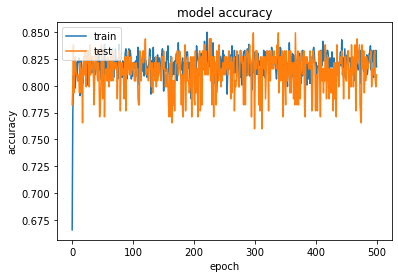

In [14]:
plot_model_history(history)

In [15]:
_, accuracy = model.evaluate(train_X, train_Y, verbose=2)

print('\nTrain accuracy:', accuracy)

712/712 - 0s - loss: 0.4352 - accuracy: 0.8357

Train accuracy: 0.83567417


In [16]:
_, accuracy = model.evaluate(dev_X, dev_Y, verbose=2)

print('\nDev accuracy:', accuracy)

179/179 - 0s - loss: 0.5013 - accuracy: 0.8101

Dev accuracy: 0.81005585


In [17]:
from kerastuner import HyperModel

# https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner
# https://www.curiousily.com/posts/hackers-guide-to-hyperparameter-tuning/

class TitanicHyperModel(HyperModel):
    def __init__(self, input_size):
        self.input_shape = (input_size, )

    def build(self, hp):
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Dropout

        model = Sequential()
        
        for layer_n in range(hp.Int("num_layers", min_value=1, max_value=6, step=1, default=6) + 1):
            units = units=hp.Int(
                f"dense_units_{layer_n}",
                min_value=8,
                max_value=64,
                step=8,
                default=64
            )
            activation=hp.Choice(
                f"dense_activation_{layer_n}",
                values=['relu', 'tanh', 'sigmoid'],
                default='relu'
            )
            
            if layer_n == 0:
                model.add(Dense(units=units, input_shape=self.input_shape, activation=activation))
            else:
                model.add(Dense(units=units, activation=activation))
            
            droupout_rate = hp.Float(
                f'dropout_{layer_n}',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )
            
            model.add(Dropout(rate=droupout_rate))
        
        model.add(Dense(1, activation="sigmoid"))
        
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            metrics=["accuracy"],
            loss="binary_crossentropy",
        )

        return model

hypermodel = TitanicHyperModel(input_size=train_X.shape[1])

In [18]:
# Dev mode

if MODE == "DEV":
    MAX_TRIALS = 20
    EXECUTION_PER_TRIAL = 2
    N_EPOCH_SEARCH = 20
else:
    MAX_TRIALS = 200
    EXECUTION_PER_TRIAL = 3
    N_EPOCH_SEARCH = 400

In [19]:
from kerastuner.tuners import RandomSearch

try:
    ATTEMPT = ATTEMPT + 1
except NameError:
    ATTEMPT = 0

tuner = RandomSearch(
    hypermodel,
    objective="val_accuracy",
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory=f'random_search_{ATTEMPT}',
    project_name='titanic'
)

tuner.search_space_summary()

In [20]:
tuner.search(train_X, train_Y, epochs=N_EPOCH_SEARCH, validation_data=(dev_X, dev_Y))

tuner.results_summary()

Train on 712 samples, validate on 179 samples
Epoch 1/400
712/712 [==============================] - 1s 1ms/sample - loss: 0.7062 - accuracy: 0.4831 - val_loss: 0.6743 - val_accuracy: 0.5866
Epoch 2/400
712/712 [==============================] - 0s 143us/sample - loss: 0.6575 - accuracy: 0.6222 - val_loss: 0.6743 - val_accuracy: 0.5866
Epoch 3/400
712/712 [==============================] - 0s 144us/sample - loss: 0.6558 - accuracy: 0.6222 - val_loss: 0.6591 - val_accuracy: 0.5866
Epoch 4/400
712/712 [==============================] - 0s 164us/sample - loss: 0.6443 - accuracy: 0.6250 - val_loss: 0.6354 - val_accuracy: 0.5866
Epoch 5/400
712/712 [==============================] - 0s 154us/sample - loss: 0.6216 - accuracy: 0.6306 - val_loss: 0.5971 - val_accuracy: 0.5866
Epoch 6/400
712/712 [==============================] - 0s 192us/sample - loss: 0.5900 - accuracy: 0.7008 - val_loss: 0.5511 - val_accuracy: 0.7933
Epoch 7/400
712/712 [==============================] - 0s 194us/sample - l

Train on 712 samples, validate on 179 samples
Epoch 1/400
712/712 [==============================] - 1s 1ms/sample - loss: 0.7399 - accuracy: 0.4874 - val_loss: 0.6917 - val_accuracy: 0.5866
Epoch 2/400
712/712 [==============================] - 0s 138us/sample - loss: 0.7219 - accuracy: 0.5435 - val_loss: 0.6723 - val_accuracy: 0.5866
Epoch 3/400
712/712 [==============================] - 0s 145us/sample - loss: 0.7093 - accuracy: 0.5253 - val_loss: 0.6585 - val_accuracy: 0.5866
Epoch 4/400
712/712 [==============================] - 0s 143us/sample - loss: 0.7007 - accuracy: 0.5562 - val_loss: 0.6501 - val_accuracy: 0.5866
Epoch 5/400
712/712 [==============================] - 0s 139us/sample - loss: 0.6558 - accuracy: 0.5871 - val_loss: 0.6440 - val_accuracy: 0.5866
Epoch 6/400
712/712 [==============================] - 0s 210us/sample - loss: 0.6660 - accuracy: 0.5632 - val_loss: 0.6384 - val_accuracy: 0.5866
Epoch 7/400
712/712 [==============================] - 0s 149us/sample - l

Train on 712 samples, validate on 179 samples
Epoch 1/400
712/712 [==============================] - 1s 2ms/sample - loss: 0.7473 - accuracy: 0.5112 - val_loss: 0.6786 - val_accuracy: 0.5866
Epoch 2/400
712/712 [==============================] - 0s 156us/sample - loss: 0.7219 - accuracy: 0.5323 - val_loss: 0.6779 - val_accuracy: 0.5866
Epoch 3/400
712/712 [==============================] - 0s 159us/sample - loss: 0.7141 - accuracy: 0.5534 - val_loss: 0.6797 - val_accuracy: 0.5866
Epoch 4/400
712/712 [==============================] - 0s 151us/sample - loss: 0.7289 - accuracy: 0.5309 - val_loss: 0.6803 - val_accuracy: 0.5866
Epoch 5/400
712/712 [==============================] - 0s 157us/sample - loss: 0.6992 - accuracy: 0.5716 - val_loss: 0.6806 - val_accuracy: 0.5866
Epoch 6/400
712/712 [==============================] - 0s 155us/sample - loss: 0.7168 - accuracy: 0.5449 - val_loss: 0.6802 - val_accuracy: 0.5866
Epoch 7/400
712/712 [==============================] - 0s 160us/sample - l

Train on 712 samples, validate on 179 samples
Epoch 1/400
712/712 [==============================] - 1s 987us/sample - loss: 0.6689 - accuracy: 0.5969 - val_loss: 0.5513 - val_accuracy: 0.7151
Epoch 2/400
712/712 [==============================] - 0s 170us/sample - loss: 0.6022 - accuracy: 0.6713 - val_loss: 0.5305 - val_accuracy: 0.7430
Epoch 3/400
712/712 [==============================] - 0s 170us/sample - loss: 0.5717 - accuracy: 0.6952 - val_loss: 0.5140 - val_accuracy: 0.7654
Epoch 4/400
712/712 [==============================] - 0s 175us/sample - loss: 0.5690 - accuracy: 0.7037 - val_loss: 0.4905 - val_accuracy: 0.8101
Epoch 5/400
712/712 [==============================] - 0s 161us/sample - loss: 0.5360 - accuracy: 0.7458 - val_loss: 0.4744 - val_accuracy: 0.8101
Epoch 6/400
712/712 [==============================] - 0s 174us/sample - loss: 0.5339 - accuracy: 0.7289 - val_loss: 0.4586 - val_accuracy: 0.8324
Epoch 7/400
712/712 [==============================] - 0s 141us/sample -

Train on 712 samples, validate on 179 samples
Epoch 1/400
712/712 [==============================] - 1s 1ms/sample - loss: 0.8438 - accuracy: 0.4213 - val_loss: 0.7472 - val_accuracy: 0.4134
Epoch 2/400
712/712 [==============================] - 0s 144us/sample - loss: 0.7673 - accuracy: 0.4565 - val_loss: 0.7041 - val_accuracy: 0.4134
Epoch 3/400
712/712 [==============================] - 0s 170us/sample - loss: 0.7410 - accuracy: 0.4831 - val_loss: 0.6812 - val_accuracy: 0.5866
Epoch 4/400
712/712 [==============================] - 0s 142us/sample - loss: 0.7145 - accuracy: 0.5225 - val_loss: 0.6744 - val_accuracy: 0.5866
Epoch 5/400
712/712 [==============================] - 0s 142us/sample - loss: 0.6894 - accuracy: 0.5815 - val_loss: 0.6726 - val_accuracy: 0.5866
Epoch 6/400
712/712 [==============================] - 0s 138us/sample - loss: 0.6928 - accuracy: 0.5829 - val_loss: 0.6724 - val_accuracy: 0.5866
Epoch 7/400
712/712 [==============================] - 0s 144us/sample - l

In [21]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'num_layers': 4,
 'dense_units_0': 16,
 'dense_activation_0': 'sigmoid',
 'dropout_0': 0.0,
 'dense_units_1': 48,
 'dense_activation_1': 'tanh',
 'dropout_1': 0.5,
 'dense_units_2': 56,
 'dense_activation_2': 'tanh',
 'dropout_2': 0.30000000000000004,
 'dense_units_3': 48,
 'dense_activation_3': 'relu',
 'dropout_3': 0.05,
 'dense_units_4': 48,
 'dense_activation_4': 'sigmoid',
 'dropout_4': 0.2,
 'dense_units_5': 24,
 'dense_activation_5': 'sigmoid',
 'dropout_5': 0.2,
 'dense_units_6': 40,
 'dense_activation_6': 'sigmoid',
 'dropout_6': 0.25,
 'learning_rate': 0.009509954648434607}

In [22]:
print("Best model")

# Get the best model tuned.
best_model = tuner.get_best_models(num_models=1)[0]

_, accuracy = best_model.evaluate(train_X, train_Y)
print(f"Tuned train accuracy: {accuracy}")

_, accuracy = best_model.evaluate(dev_X, dev_Y)
print(f"Tuned dev accuracy: {accuracy}")

best_model.summary()

Best model
712/712 [==============================] - 0s 222us/sample - loss: 0.3786 - accuracy: 0.8399
Tuned train accuracy: 0.8398876190185547
179/179 [==============================] - 0s 98us/sample - loss: 0.4096 - accuracy: 0.8547
Tuned dev accuracy: 0.8547486066818237
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                816       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 56)     

In [23]:
def store_predictions(model, submission_name):
    predictions = model.predict(test_data_X)

    predictions = np.round(predictions).astype(np.uint8).reshape((-1))

    print(f"{submission_name}:\n{predictions}")
    
    output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
    output.to_csv(f"{submission_name}.csv", index=False)

In [24]:
store_predictions(model, "dl_submission")
store_predictions(model, "dl_tuned_submission")

dl_submission:
[0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 0 1 1 0 0 1 0 0 0]
dl_tuned_submission:
[0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0